# Vehicle Dtection Via  Traditional Computer Vision

## Project Steps:
        1.feature extraction
        2.train classifier
        3.sliding windows
        4.false positives

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import utils
import random
%matplotlib inline

## 1.Feature Extraction 

### Explore Data
This dataset is a combination of the 'GTI vehicle image database', the 'KITTI vision benchmark suite', and examples extracted from the project video itself.

In [2]:
path_vehic = './data/vehicles/'
path_nonvehic = './data/non-vehicles/'
ls_vehic = ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
ls_nonvehic = ['GTI', 'Extras']

In [3]:
vehicles = []
non_vehicles = []
for folder in ls_vehic:
    img_folder = path_vehic + folder
    img_paths = glob.glob(img_folder + '/*.png')
    vehicles = vehicles + img_paths
for folder in ls_nonvehic:
    img_folder = path_nonvehic + folder
    img_paths = glob.glob(img_folder + '/*.png')
    non_vehicles = non_vehicles + img_paths
print('Number of vehicles:', len(vehicles))
print('Number of non-vehicles:', len(non_vehicles))

Number of vehicles: 8792
Number of non-vehicles: 8968


### Display Examples of Data

Shape of examples: (16, 64, 64, 3)


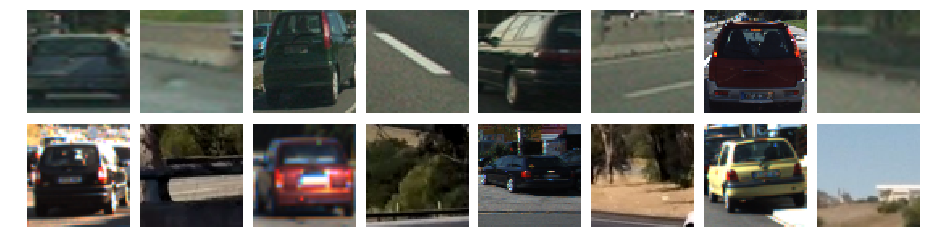

In [4]:
'''
matplotlib.image.imread will read .png in on a scale of 0 to 1, but cv2.imread() will scale them from 0 to 255.
'''
examples = []
for i in range(8):
    rand_num = random.randint(0,1000)
    idx = i*1000 + rand_num
    examples.append(cv2.cvtColor(cv2.imread(vehicles[idx]), cv2.COLOR_BGR2RGB))
    examples.append(cv2.cvtColor(cv2.imread(non_vehicles[idx]), cv2.COLOR_BGR2RGB))
examples = np.asarray(examples)
print('Shape of examples:', examples.shape)
utils.display(examples, size=(2,8), fig_size=(16,4))

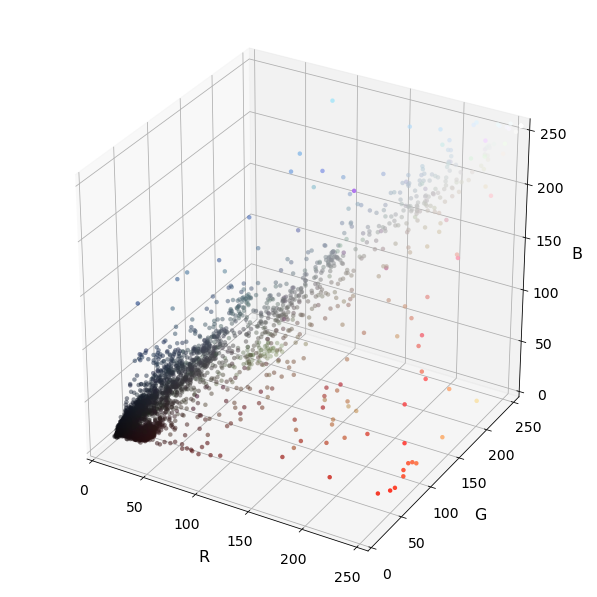

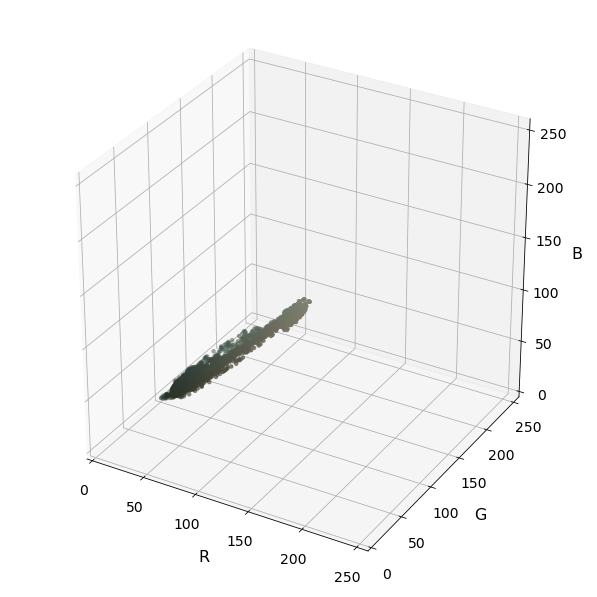

In [5]:
utils.plot3d(examples[6],examples[6]/255)
utils.plot3d(examples[7],examples[7]/255)

### Extract Color Features on Examples

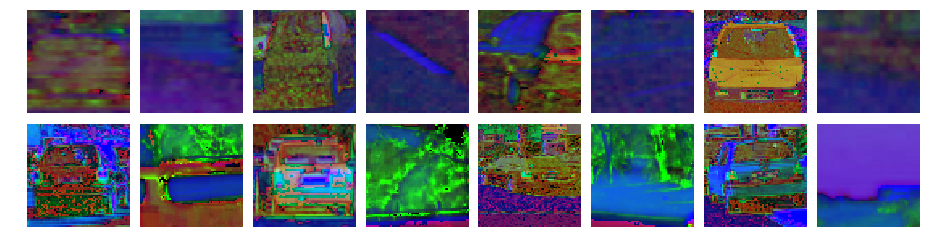

In [6]:
hsv_examples = []
for img in examples:
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_examples.append(hsv)
utils.display(hsv_examples, size=(2,8), fig_size=(16,4))

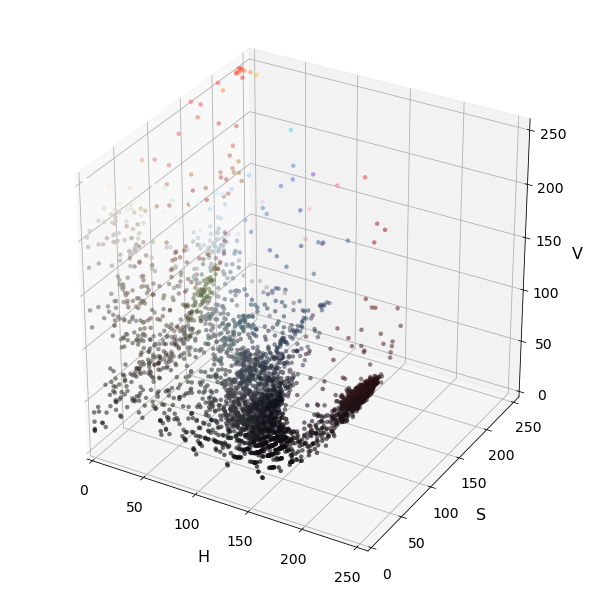

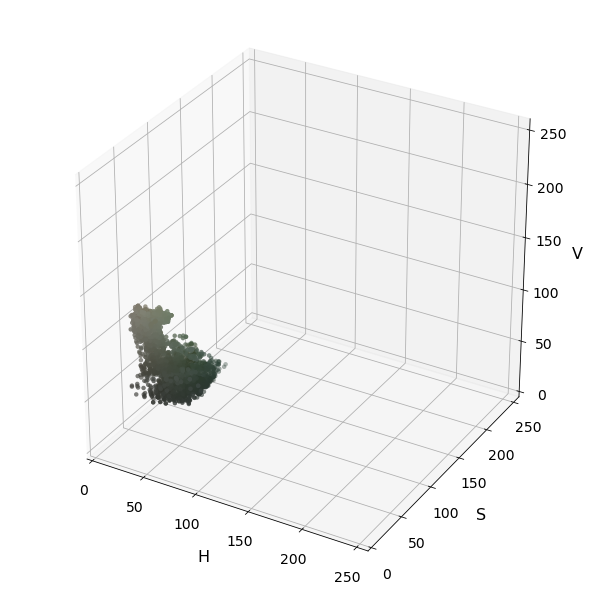

In [7]:
utils.plot3d(hsv_examples[6], examples[6]/255, axis_labels=list("HSV"))
utils.plot3d(hsv_examples[7], examples[7]/255, axis_labels=list("HSV"))

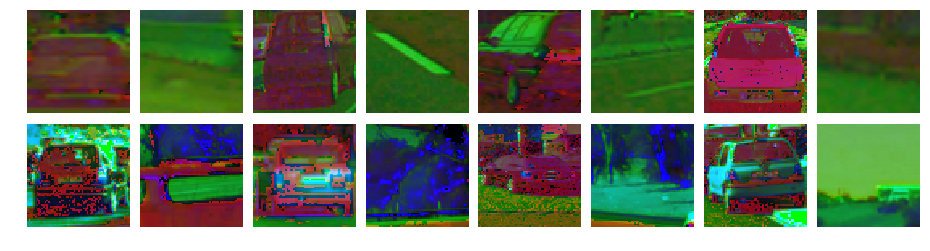

In [8]:
hls_examples = []
for img in examples:
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_examples.append(hls)
utils.display(hls_examples, size=(2,8), fig_size=(16,4))

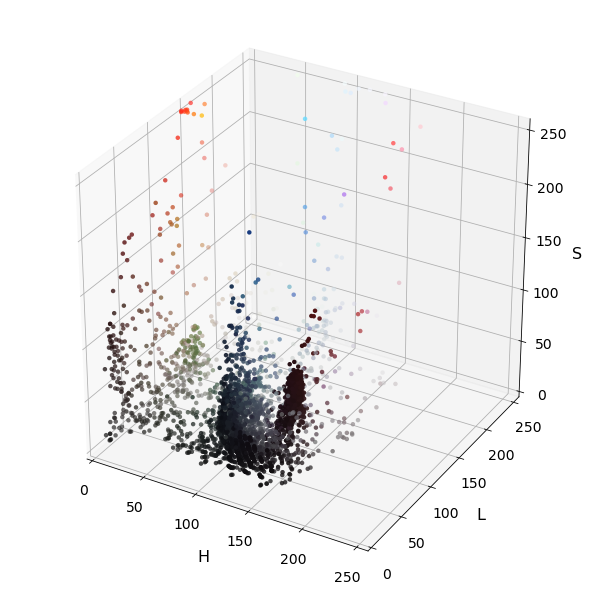

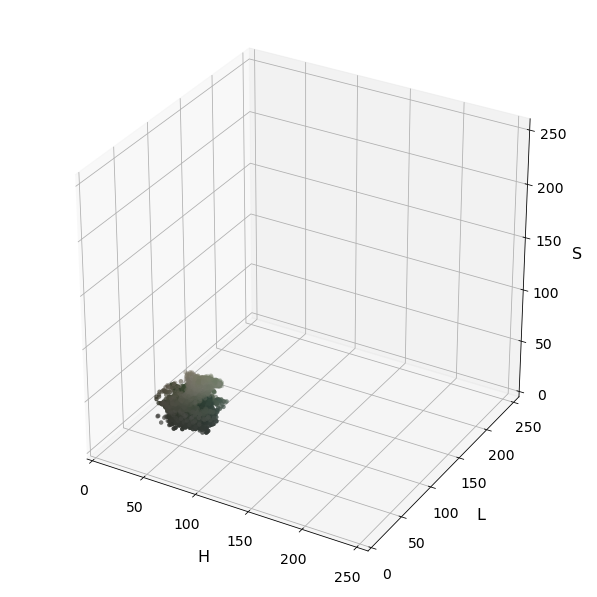

In [9]:
utils.plot3d(hls_examples[6], examples[6]/255, axis_labels=list("HLS"))
utils.plot3d(hls_examples[7], examples[7]/255, axis_labels=list("HLS"))

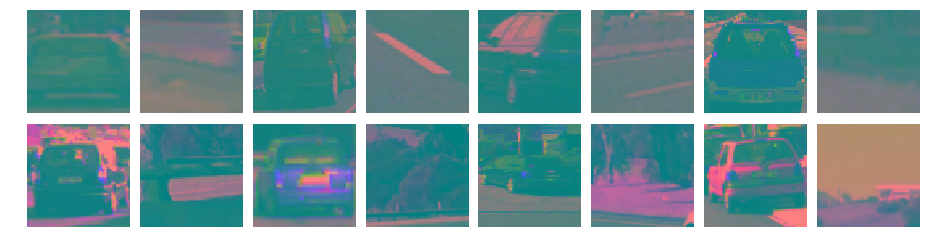

In [10]:
yuv_examples = []
for img in examples:
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv_examples.append(yuv)
utils.display(yuv_examples, size=(2,8), fig_size=(16,4))

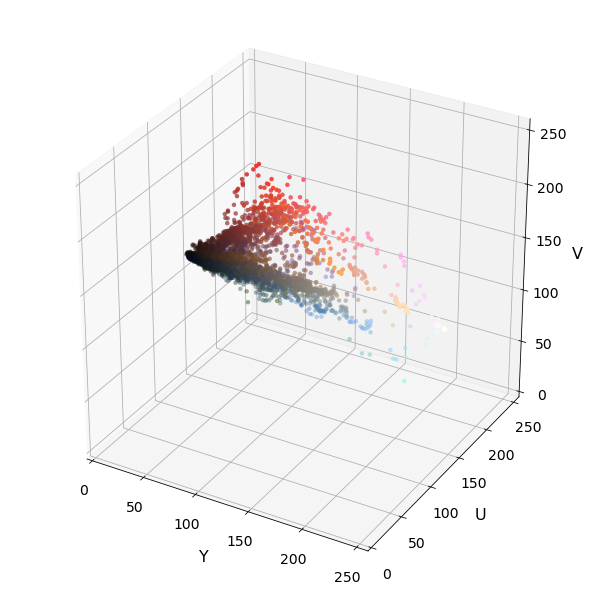

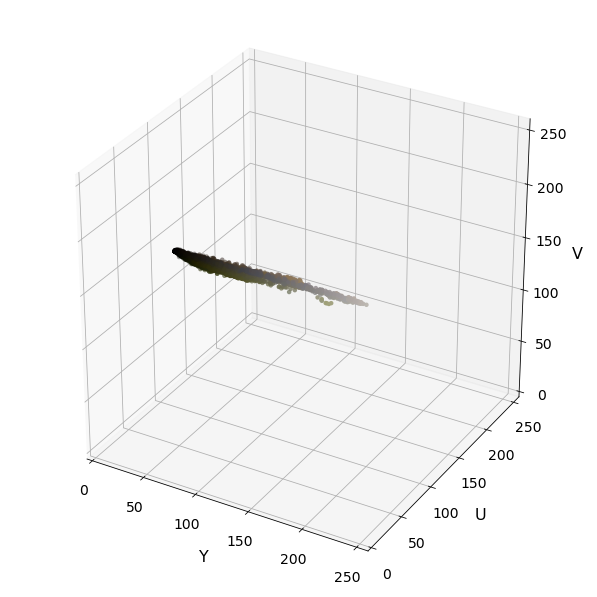

In [11]:
utils.plot3d(yuv_examples[10], examples[10]/255, axis_labels=list("YUV"))
utils.plot3d(yuv_examples[11], examples[11]/255, axis_labels=list("YUV"))

From the exploring above, it seems that the S(saturation) layer of an image can be useful as a feature.

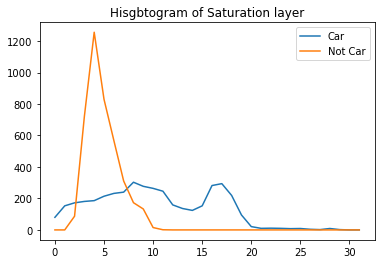

In [12]:
s_features6 = utils.get_s_features(examples[6])
plt.plot(s_features6)
s_features7 = utils.get_s_features(examples[7])
plt.plot(s_features7)
plt.legend(['Car', 'Not Car'], loc = 'upper right')
plt.title('Hisgbtogram of Saturation layer')

### Extract Grandient Features on Examples

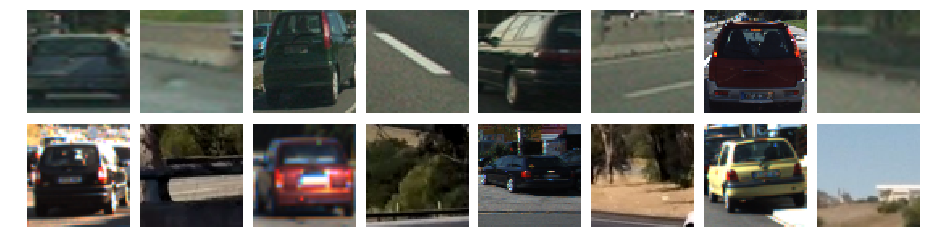

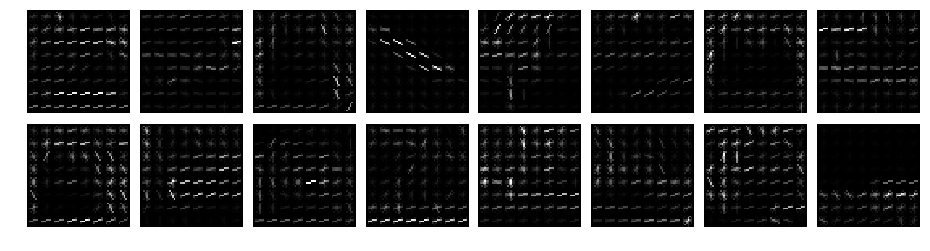

In [16]:
hog_examples = []
for example in examples:
    hog_features, hog_image = utils.get_hog_features(cv2.cvtColor(example, cv2.COLOR_RGB2GRAY), orient= 9, 
                                           pix_per_cell= 8, cell_per_block= 2, vis=True, feature_vec=True)
    hog_examples.append(hog_image)
utils.display(examples, size=(2,8), fig_size=(16,4))
utils.display(hog_examples, size=(2,8), fig_size=(16,4), cm='gray')

### Extract Image Features for Training

In [17]:
vehicles_feat = []
for path in vehicles:
    
    bgr = cv2.imread(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    img_features = utils.extract_features(rgb, orient=9, pix_per_cell=8, cell_per_block=2)
    
    vehicles_feat.append(img_features)

print('Shape of vehicles_feat:', np.array(vehicles_feat).shape)

Shape of vehicles_feat: (8792, 1796)


In [18]:
non_vehicles_feat = []
for path in non_vehicles:
    
    bgr = cv2.imread(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    img_features = utils.extract_features(rgb, orient=9, pix_per_cell=8, cell_per_block=2)
    
    non_vehicles_feat.append(img_features)
    
print('Shape of non_vehicles_feat:', np.array(non_vehicles_feat).shape)

Shape of non_vehicles_feat: (8968, 1796)


### Prepare Inputs And Labels for Traning Classifier

In [19]:
'''
StandardScale requires data type as float64
'''
X = np.vstack((vehicles_feat, non_vehicles_feat)).astype(np.float64)
y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles))))

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (17760, 1796)
Shape of y: (17760,)


## 2.Train Classifier

In [20]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Prepare Training and Testing Set

In [21]:
rand = random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = rand)

### Normolize Input Data

In [22]:
'''
Only fit the scaler on the training data, and then transform both the training and test sets using the scaler. 
If I provide both the training and test set to the scaler, 
I am allowing the model a peek into the values contained in the test set.
'''
#### Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
#### Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [23]:
print('Shape of X_train:', scaled_X_train.shape)
print('Shape of X_test:', scaled_X_test.shape)

Shape of X_train: (13320, 1796)
Shape of X_test: (4440, 1796)


### Train and Save Classifier Model

In [45]:
import pickle

svc = LinearSVC(C=0.01)
svc.fit(scaled_X_train, y_train)

svc_model = pickle.dumps(svc)
print('Model saved')

Model saved


### Accuracy and Prediction

In [48]:
print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))

Test Accuracy of SVC =  0.963288288288


In [49]:
'''
SVC.predict expected 2D array
'''
print('Prediction of image', idx, ':', svc.predict(scaled_X_test[0:10].reshape(10,-1)))
print('Label of image', idx, ':', y_test[0:10])

Prediction of image 1214 : [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
Label of image 1214 : [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]


### Checkpoint

In [50]:
clf = pickle.loads(svc_model)

## 3.Sliding Windows